In [ ]:
!pip install timm
!pip install transformers

In [ ]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

In [ ]:
!pip install kaggle --upgrade
os.environ['KAGGLE_USERNAME'] = "XXXXX"
os.environ['KAGGLE_KEY'] = "XXXXXXXXXXXXXX"

### For Flickr 8k
!kaggle datasets download -d adityajn105/flickr8k
!unzip flickr8k.zip
dataset = "8k"


### For Flickr 30k
# !kaggle datasets download -d hsankesara/flickr-image-dataset
# !unzip flickr-image-dataset.zip
# dataset = "30k"

## Some pre-preocessing

In [ ]:
if dataset == "8k":
  df = pd.read_csv("captions.txt")
  df['id'] = [id_ for id_ in range(df.shape[0] // 5) for _ in range(5)]
  df.to_csv("captions.csv", index=False)
  df = pd.read_csv("captions.csv")
  image_path = "/content/Images"
  captions_path = "/content"
# elif dataset == "30k":
#   df = pd.read_csv("/content/flickr30k_images/results.csv", delimiter="|")
#   df.columns = ['image', 'caption_number', 'caption']
#   df['caption'] = df['caption'].str.lstrip()
#   df['caption_number'] = df['caption_number'].str.lstrip()
#   df.loc[19999, 'caption_number'] = "4"
#   df.loc[19999, 'caption'] = "A dog runs across the grass ."
#   ids = [id_ for id_ in range(len(df) // 5) for _ in range(5)]
#   df['id'] = ids
#   df.to_csv("captions.csv", index=False)
#   image_path = "/content/flickr30k_images/flickr30k_images"
#   captions_path = "/content"

df.head()

In [ ]:
class CFG:
    debug = False
    image_path = image_path
    captions_path = captions_path
    batch_size = 32
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.1

## Utils

In [ ]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


## Dataset

In [ ]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and captions must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

## Image Encoder

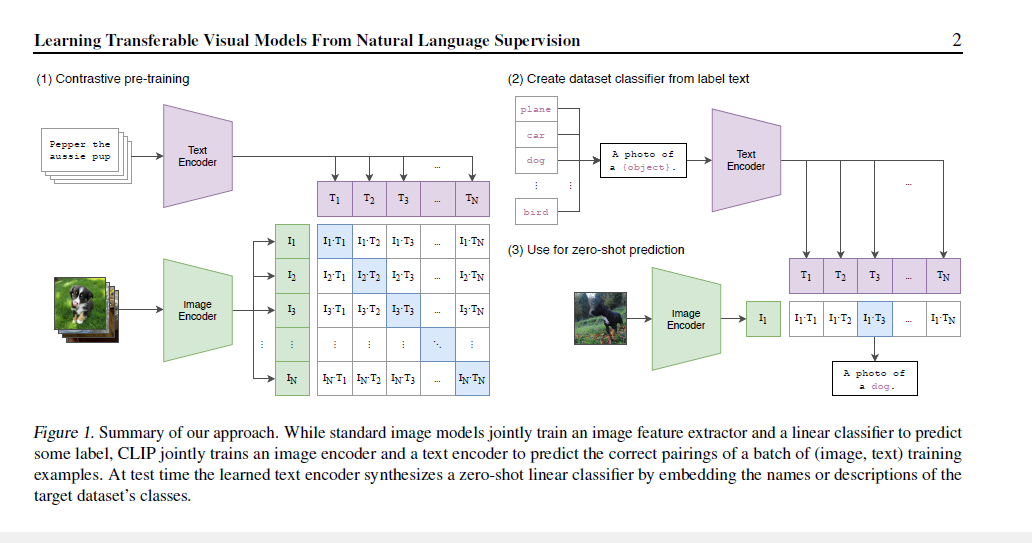

In [ ]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

## Text Encoder

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

## Projection Head

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=CFG.projection_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

## CLIP

In [ ]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

So, in the best case scenario, text_embeddings and image_embedding matricies should be the same because they are describing similar things. Let's think now: if this happens, what would the logits matrix be like? Let's see with a simple example!

In [ ]:
# A simple Example

batch_size = 4
dim = 256
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T
print(F.softmax(out, dim=-1))

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


## Train

In [ ]:
def make_train_valid_dfs():
    # Read the CSV file containing image captions
    dataframe = pd.read_csv(f"{CFG.captions_path}/captions.csv")

    # Determine the maximum ID in the DataFrame and increment it by 1 if not in debug mode
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100

    # Generate an array of image IDs ranging from 0 to max_id
    image_ids = np.arange(0, max_id)

    # Randomly select 20% of the image IDs as validation IDs
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )

    # Select the remaining IDs as training IDs
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]

    # Filter the DataFrame to create separate DataFrames for training and validation data
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)

    # Return the training and validation DataFrames
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    # Retrieve transformations based on the mode
    transforms = get_transforms(mode=mode)

    # Initialize a CLIPDataset object with image filenames and captions, tokenizer, and transformations
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )

    # Create a DataLoader using the initialized dataset
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )

    # Return the DataLoader
    return dataloader


In [ ]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    # Initialize an average meter to keep track of the loss
    loss_meter = AvgMeter()
    # Create a tqdm progress bar for the training loader
    tqdm_object = tqdm(train_loader, total=len(train_loader))

    # Iterate over batches in the training data loader
    for batch in tqdm_object:
        # Move batch data to the device specified in CFG.device and exclude the 'caption' key
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        # Forward pass: compute the loss for the current batch
        loss = model(batch)
        # Reset gradients
        optimizer.zero_grad()
        # Backpropagation: compute gradients of the loss with respect to model parameters
        loss.backward()
        # Optimization step: update model parameters
        optimizer.step()
        # If step is set to "batch", adjust the learning rate scheduler
        if step == "batch":
            lr_scheduler.step()

        # Compute the number of samples in the batch
        count = batch["image"].size(0)
        # Update the loss meter with the batch loss
        loss_meter.update(loss.item(), count)
        # Update tqdm progress bar with current training loss and learning rate
        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))

    # Return the loss meter containing the average loss for the epoch
    return loss_meter

def valid_epoch(model, valid_loader):
    # Initialize an average meter to keep track of the loss
    loss_meter = AvgMeter()

    # Create a tqdm progress bar for the validation loader
    tqdm_object = tqdm(valid_loader, total=len(valid_loader))

    # Iterate over batches in the validation data loader
    for batch in tqdm_object:
        # Move batch data to the device specified in CFG.device and exclude the 'caption' key
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        # Forward pass: compute the loss for the current batch
        loss = model(batch)
        # Compute the number of samples in the batch
        count = batch["image"].size(0)
        # Update the loss meter with the batch loss
        loss_meter.update(loss.item(), count)
        # Update tqdm progress bar with current validation loss
        tqdm_object.set_postfix(valid_loss=loss_meter.avg)

    # Return the loss meter containing the average validation loss
    return loss_meter

def main():
    # Prepare training and validation data frames
    train_df, valid_df = make_train_valid_dfs()

    # Initialize the DistilBERT tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)

    # Build data loaders for training and validation sets
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    # Initialize the CLIP model and move it to the specified device
    model = CLIPModel().to(CFG.device)

    # Define parameters for optimization
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]

    # Initialize the optimizer (AdamW) with specified parameters and weight decay
    optimizer = torch.optim.AdamW(params, weight_decay=0.)

    # Initialize the learning rate scheduler (ReduceLROnPlateau)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )

    # Set the step for learning rate scheduling
    step = "epoch"

    # Initialize best_loss to positive infinity
    best_loss = float('inf')

    # Iterate over epochs
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")

        # Set the model to train mode
        model.train()

        # Perform training for the current epoch
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)

        # Set the model to evaluation mode
        model.eval()

        # Perform validation with the current model
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)

        # If the current validation loss is better than the best loss seen so far, save the model
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")

        # Adjust the learning rate based on the current validation loss
        lr_scheduler.step(valid_loss.avg)



Running the next cell start training the model. Put the kernel on GPU mode. Every epoch should take about 8 minutes on GPU if you are using 8k version (even one epoch is enough!). It can take some seconds before training actually starts because we are going to encode all the captions once in the train and valid dataset, so please don't stop it! Every thing is working fine.

In [ ]:
main()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch: 1


  0%|          | 0/1012 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/253 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 3


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

## Inference

In [ ]:
def get_image_embeddings(valid_df, model_path):
    # Initialize the DistilBERT tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    # Build a data loader for the validation set
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    # Initialize the CLIP model and load the pretrained weights
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()

    # Initialize an empty list to store the image embeddings
    valid_image_embeddings = []

    # Iterate over batches in the validation data loader
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            # Extract image features using the image encoder
            image_features = model.image_encoder(batch["image"].to(CFG.device))

            # Project image features to obtain image embeddings
            image_embeddings = model.image_projection(image_features)

            # Append image embeddings to the list
            valid_image_embeddings.append(image_embeddings)

    # Concatenate image embeddings from all batches
    return model, torch.cat(valid_image_embeddings)


In [ ]:
# First, obtain the validation DataFrame using make_train_valid_dfs
_, valid_df = make_train_valid_dfs()

# Then, use the get_image_embeddings function to get the model and image embeddings
model, image_embeddings = get_image_embeddings(valid_df, "best.pt")


  0%|          | 0/253 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    # Tokenize the query
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])

    # Prepare query batch
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }

    # Compute text embeddings
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    # Normalize image and text embeddings
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)

    # Calculate dot product similarity between text and image embeddings
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    # Find top-k similar images for each query
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]

    # Visualize the top-k similar images
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()


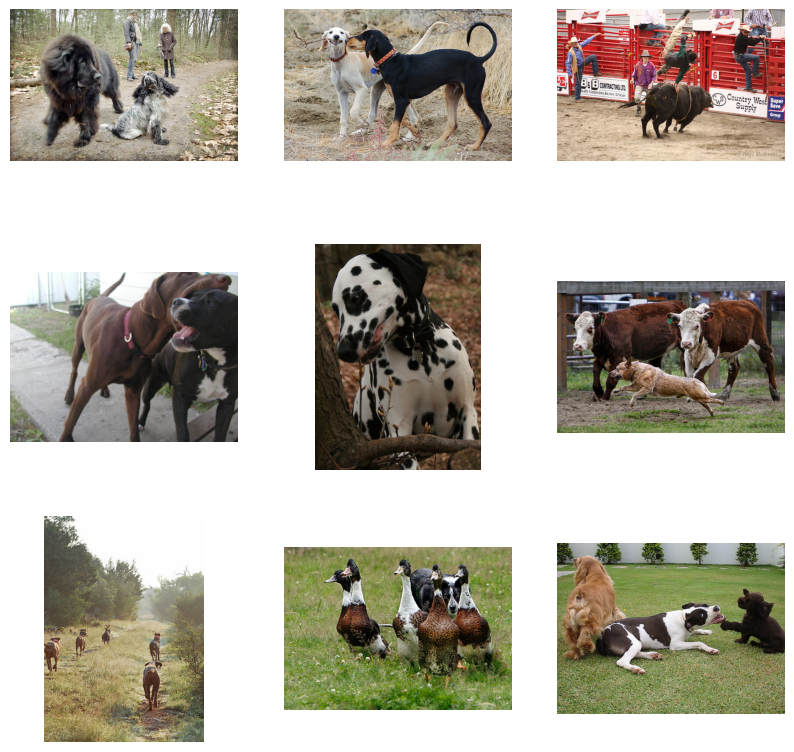

In [ ]:
find_matches(model,
             image_embeddings,
             query="animals",
             image_filenames=valid_df['image'].values,
             n=9)